# Credit Risk Analysis: Loan Default Prediction
## NB02 — Data Cleaning & Preprocessing

### Cleaning Decisions Made in NB01

This notebook resolves every data quality issue surfaced in NB01. The decisions below were made collaboratively — this cell serves as an audit trail so anyone reading this notebook understands what was changed, and why.

| # | Issue | Decision |
|---|-------|----------|
| 1 | Post-loan leakage columns (`total_pymnt`, `recoveries`, etc.) | **Drop** — these are known only *after* the loan resolves; including them would be data leakage and produce an unrealistically perfect model |
| 2 | Structurally empty columns (99–100% missing: joint application, installment account fields) | **Drop** — dataset predates collection of these fields; no usable signal |
| 3 | Informatively missing columns (`mths_since_last_delinq`, `mths_since_last_record`, `mths_since_last_major_derog`) | **Create binary flag + fill with 999 sentinel** — missing means "never happened," which is itself a risk signal |
| 4 | `annual_inc` outliers (max $8.7M) | **Cap at 99th percentile ($240K)** — extreme values would distort model training |
| 5 | `revol_util` > 100% (impossible values, max 892%) | **Null out, then impute with median** — values above 100% are data errors |
| 6 | `emp_length` missing (5.6%) | **Treat as "Unknown" category** — preserves the signal that these borrowers didn't report employment length |
| 7 | Administrative/identifier columns | **Drop** — `id`, `member_id`, `url`, `desc`, `title`, `zip_code`, `emp_title`, `pymnt_plan` carry no predictive signal |
| 8 | Near-duplicate columns (`funded_amnt` ≈ `loan_amnt` at r=0.998) | **Drop duplicates** — keep `loan_amnt`; drop `funded_amnt`, `funded_amnt_inv` |

**Remaining moderate missingness** (`tot_cur_bal`, `tot_coll_amt`, `total_rev_hi_lim` at ~25% missing): **Median imputation** — these are bureau-reported balance fields; median fill is appropriate as missing is likely due to data vintage, not informative absence.


In [ ]:
from pathlib import Path
import os

# Locate project root by walking up until we find the .git directory.
# This makes the notebook portable — no hardcoded filesystem paths.
root = Path.cwd()
while not (root / '.git').exists() and root != root.parent:
    root = root.parent
os.chdir(root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11
sns.set_theme(style='whitegrid', palette='muted')

# ── Load raw data — same source as NB01 ──────────────────────────────────────
print("Loading raw dataset...")
df = pd.read_csv('data/raw/loan/loan.csv', low_memory=False)
print(f"Raw shape: {df.shape[0]:,} rows × {df.shape[1]} columns  ✓ matches NB01")

# ── Filter to resolved loans only (same logic as NB01) ───────────────────────
DEFAULT_STATUSES = {'Charged Off', 'Default', 'Late (31-120 days)', 'Late (16-30 days)',
                    'Does not meet the credit policy. Status:Charged Off'}
PAID_STATUSES    = {'Fully Paid', 'Does not meet the credit policy. Status:Fully Paid'}

df = df[df['loan_status'].isin(DEFAULT_STATUSES | PAID_STATUSES)].copy()
df['target'] = df['loan_status'].isin(DEFAULT_STATUSES).astype(int)

print(f"Resolved loans shape: {df.shape[0]:,} rows × {df.shape[1]} columns  ✓ matches NB01")
print(f"Target distribution: {df['target'].value_counts(normalize=True).mul(100).round(1).to_dict()}")

### Step 1: Fix Sentinel / Coded Values

Before dropping or imputing, we correct values that are technically present but actually invalid. The key case here is `revol_util` — credit utilization cannot exceed 100% (you cannot spend more than your total credit limit), so any value above 100 is a data entry error, not a real measurement.


In [2]:
# ── Fix revol_util: null out impossible values (> 100%) ──────────────────────
n_impossible = (df['revol_util'] > 100).sum()
print(f"revol_util values > 100%: {n_impossible:,} rows — nulling out")
df.loc[df['revol_util'] > 100, 'revol_util'] = np.nan

# ── Verify fix ────────────────────────────────────────────────────────────────
print(f"revol_util max after fix: {df['revol_util'].max():.1f}%  ✓ (should be ≤ 100)")
print(f"revol_util missing after fix: {df['revol_util'].isnull().sum():,}")


revol_util values > 100%: 702 rows — nulling out
revol_util max after fix: 100.0%  ✓ (should be ≤ 100)
revol_util missing after fix: 953


### Step 2: Drop Columns

We systematically drop four categories of columns. Each drop is documented with a rationale — this matters for reproducibility and for anyone reviewing the methodology.


In [3]:
# ── Category 1: Post-loan outcome / data leakage columns ────────────────────
# These fields are only known AFTER the loan resolves — they encode the outcome
# rather than predict it. Including them would give a fraudulently perfect model.
leakage_cols = [
    'out_prncp', 'out_prncp_inv',           # outstanding principal (post-issuance)
    'total_pymnt', 'total_pymnt_inv',         # total payments received
    'total_rec_prncp', 'total_rec_int',       # payment breakdown
    'total_rec_late_fee',                     # late fees collected
    'recoveries', 'collection_recovery_fee',  # post-default recovery amounts
    'last_pymnt_d', 'last_pymnt_amnt',        # last payment date and amount
    'next_pymnt_d',                           # next scheduled payment (only for current loans)
    'last_credit_pull_d',                     # credit pull at servicing, not origination
]
leakage_cols = [c for c in leakage_cols if c in df.columns]
print(f"Dropping {len(leakage_cols)} leakage columns: {leakage_cols}")
df.drop(columns=leakage_cols, inplace=True)

# ── Category 2: Structurally empty columns (≥99% missing) ───────────────────
# These fields were added to the Lending Club platform after most loans in this
# dataset were issued. They are missing for nearly every record — no signal to extract.
empty_cols = [
    'annual_inc_joint', 'dti_joint', 'verification_status_joint',  # joint application fields
    'il_util', 'mths_since_rcnt_il', 'open_acc_6m',                # installment account fields
    'open_il_6m', 'open_il_12m', 'open_il_24m', 'total_bal_il',
    'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
    'inq_fi', 'total_cu_tl', 'inq_last_12m',
]
empty_cols = [c for c in empty_cols if c in df.columns]
print(f"Dropping {len(empty_cols)} structurally empty columns")
df.drop(columns=empty_cols, inplace=True)

# ── Category 3: Administrative / identifier columns ───────────────────────────
# These are metadata fields with no predictive power for credit risk.
# emp_title has 139k unique values — too high-cardinality for any meaningful encoding.
admin_cols = ['id', 'member_id', 'url', 'desc', 'title', 'zip_code',
              'emp_title', 'pymnt_plan', 'loan_status']
admin_cols = [c for c in admin_cols if c in df.columns]
print(f"Dropping {len(admin_cols)} administrative columns (incl. raw loan_status — target already created)")
df.drop(columns=admin_cols, inplace=True)

# ── Category 4: Near-duplicate columns ───────────────────────────────────────
# funded_amnt and funded_amnt_inv correlate with loan_amnt at r=0.998 and r=0.997.
# They add redundancy without adding signal.
dup_cols = ['funded_amnt', 'funded_amnt_inv']
dup_cols = [c for c in dup_cols if c in df.columns]
print(f"Dropping {len(dup_cols)} near-duplicate columns: {dup_cols}")
df.drop(columns=dup_cols, inplace=True)

print()
print(f"Shape after drops: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Columns removed: {887379 - df.shape[0]} rows, {74 + 1 - df.shape[1]} columns")  # +1 for target


Dropping 13 leakage columns: ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d']
Dropping 17 structurally empty columns


Dropping 9 administrative columns (incl. raw loan_status — target already created)
Dropping 2 near-duplicate columns: ['funded_amnt', 'funded_amnt_inv']

Shape after drops: 270,887 rows × 34 columns
Columns removed: 616492 rows, 41 columns


### Step 3: Missing Value Imputation

We apply different strategies based on the *type* of missingness — this is a critical distinction that most tutorials gloss over.

**Three types of missingness in this dataset:**
1. **Informative missingness** — the fact that a value is missing *is itself information* (e.g., no delinquency history). Imputing with the median would destroy this signal.
2. **Random missingness** — the value is missing for administrative/data collection reasons unrelated to the borrower's risk profile. Median imputation is appropriate.
3. **Structural missingness** — the field doesn't apply to this record (joint application fields for individual borrowers). These were already dropped in Step 2.


In [4]:
# ── Informatively missing: create binary flags + sentinel fill ───────────────
# These three columns are missing when the event (delinquency, public record,
# major derogatory mark) has NEVER occurred. We capture this in two ways:
#   1. A binary flag: 1 if the event ever happened, 0 if never
#   2. The original column filled with 999 (a large sentinel meaning "never")
#      This lets tree models learn different behavior for "never" vs. "long ago"

informative_missing_cols = {
    'mths_since_last_delinq':    'has_delinquency',
    'mths_since_last_record':    'has_public_record',
    'mths_since_last_major_derog': 'has_major_derog',
}

for col, flag_col in informative_missing_cols.items():
    if col not in df.columns:
        continue
    missing_before = df[col].isnull().sum()
    # Binary flag: 1 = event happened (value present), 0 = never happened (was null)
    df[flag_col] = df[col].notnull().astype(int)
    # Sentinel fill: 999 means "never — no months to report"
    df[col] = df[col].fillna(999)
    print(f"  {col}: {missing_before:,} nulls → filled with 999 | '{flag_col}' flag created")
    print(f"    {flag_col} distribution: {df[flag_col].value_counts().to_dict()}")

print()


  mths_since_last_delinq: 149,189 nulls → filled with 999 | 'has_delinquency' flag created
    has_delinquency distribution: {0: 149189, 1: 121698}
  mths_since_last_record: 235,810 nulls → filled with 999 | 'has_public_record' flag created
    has_public_record distribution: {0: 235810, 1: 35077}
  mths_since_last_major_derog: 218,906 nulls → filled with 999 | 'has_major_derog' flag created
    has_major_derog distribution: {0: 218906, 1: 51981}



In [5]:
# ── emp_length: treat missing as 'Unknown' category ──────────────────────────
# We add "Unknown" as a valid category rather than imputing with the mode (10+ years).
# A borrower who didn't report employment length is different from one who reported 10+ years,
# and we want the model to learn that distinction.
print(f"emp_length before: {df['emp_length'].isnull().sum():,} nulls")
df['emp_length'] = df['emp_length'].fillna('Unknown')
print(f"emp_length after:  {df['emp_length'].isnull().sum()} nulls")
print(f"emp_length value counts:\n{df['emp_length'].value_counts().to_string()}")
print()


emp_length before: 10,863 nulls
emp_length after:  0 nulls
emp_length value counts:
emp_length
10+ years    81939
2 years      25261
< 1 year     22686
3 years      21873
5 years      19150
1 year       18224
4 years      17295
6 years      15676
7 years      14964
8 years      12692
Unknown      10863
9 years      10264



In [6]:
# ── Numeric columns: median imputation ────────────────────────────────────────
# For remaining numeric columns with missing values, we impute with the column median.
# Median is preferred over mean for skewed distributions (which most financial variables are)
# because it's less sensitive to the extreme outliers we saw in NB01.
#
# Columns covered:
#   - revol_util: after nulling impossible values, ~0.5% missing → median fill
#   - tot_cur_bal, tot_coll_amt, total_rev_hi_lim: ~25% missing → median fill
#   - annual_inc, dti, delinq_2yrs, inq_last_6mths, open_acc, pub_rec,
#     revol_bal, total_acc, collections_12_mths_ex_med, acc_now_delinq: small % missing

# Identify numeric columns with remaining missing values
num_cols_with_missing = [
    c for c in df.select_dtypes(include=[np.number]).columns
    if c != 'target' and df[c].isnull().sum() > 0
]

print(f"Numeric columns needing median imputation ({len(num_cols_with_missing)} columns):")
medians = {}
for col in num_cols_with_missing:
    n_missing = df[col].isnull().sum()
    median_val = df[col].median()
    medians[col] = median_val
    df[col] = df[col].fillna(median_val)
    print(f"  {col:<35} {n_missing:>8,} nulls filled with median={median_val:.2f}")

print()
print(f"Remaining nulls in numeric columns: {df[num_cols_with_missing].isnull().sum().sum()}")


Numeric columns needing median imputation (12 columns):
  annual_inc                                 4 nulls filled with median=62000.00
  delinq_2yrs                               29 nulls filled with median=0.00
  inq_last_6mths                            29 nulls filled with median=1.00
  open_acc                                  29 nulls filled with median=10.00
  pub_rec                                   29 nulls filled with median=0.00
  revol_util                               953 nulls filled with median=55.90
  total_acc                                 29 nulls filled with median=23.00
  collections_12_mths_ex_med               145 nulls filled with median=0.00
  acc_now_delinq                            29 nulls filled with median=0.00
  tot_coll_amt                          66,623 nulls filled with median=0.00
  tot_cur_bal                           66,623 nulls filled with median=78983.00
  total_rev_hi_lim                      66,623 nulls filled with median=22100.00

Rema

In [7]:
# ── Categorical columns: check for remaining nulls ───────────────────────────
cat_cols_with_missing = [
    c for c in df.select_dtypes(include=['object']).columns
    if df[c].isnull().sum() > 0
]
print(f"Categorical columns with remaining nulls:")
if cat_cols_with_missing:
    for col in cat_cols_with_missing:
        n = df[col].isnull().sum()
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"  {col}: {n:,} nulls filled with mode='{mode_val}'")
else:
    print("  None — all categorical columns are complete  ✓")


Categorical columns with remaining nulls:


  earliest_cr_line: 29 nulls filled with mode='Oct-2000'


### Step 4: Outlier Treatment

We cap `annual_inc` at the 99th percentile. This is called **Winsorization** — a standard technique where you clip extreme values to a defined boundary rather than removing the rows entirely. Removing rows would reduce our training data; capping preserves the rows while reducing the distorting effect of extreme values on model training.

We leave other features uncapped because our primary models (Random Forest, XGBoost) are tree-based and inherently robust to outliers — they split on thresholds, not distances, so extreme values only affect where one split boundary sits.


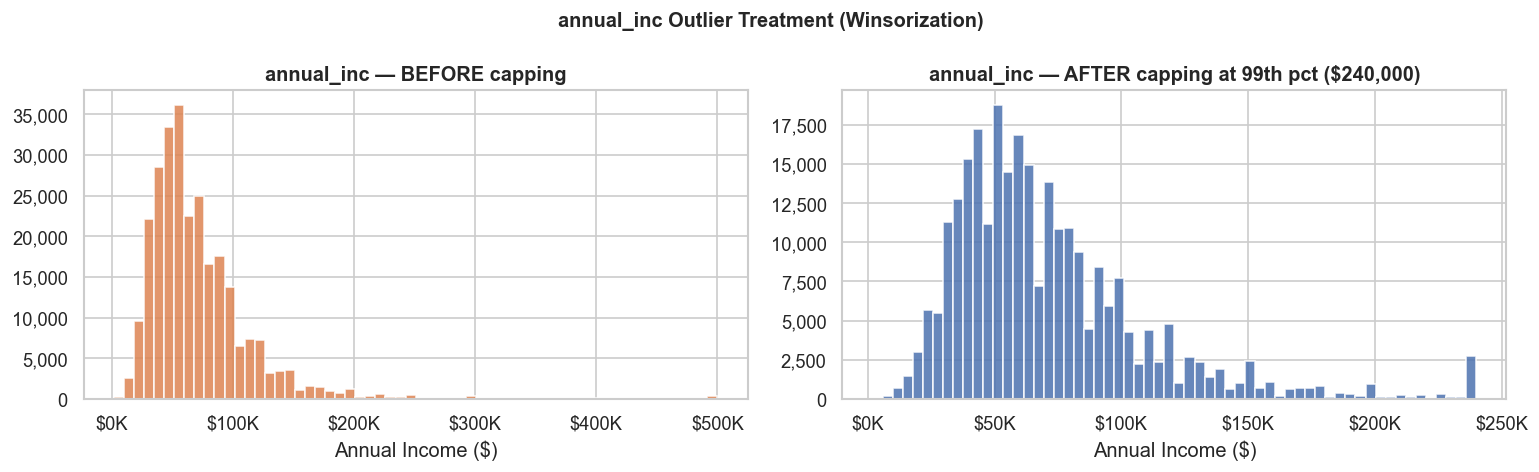

Capped at: $240,000
New max:   $240,000
New mean:  $71,131  (was ~$72,400 before — slight downward shift from removing extreme values)


In [8]:
# ── annual_inc: cap at 99th percentile ────────────────────────────────────────
cap_99 = df['annual_inc'].quantile(0.99)

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Before
axes[0].hist(df['annual_inc'].clip(upper=500_000), bins=60,
             color='#DD8452', edgecolor='white', alpha=0.85)
axes[0].set_title('annual_inc — BEFORE capping', fontweight='bold')
axes[0].set_xlabel('Annual Income ($)')
axes[0].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))

# Apply cap
df['annual_inc'] = df['annual_inc'].clip(upper=cap_99)

# After
axes[1].hist(df['annual_inc'], bins=60, color='#4C72B0', edgecolor='white', alpha=0.85)
axes[1].set_title(f'annual_inc — AFTER capping at 99th pct (${cap_99:,.0f})', fontweight='bold')
axes[1].set_xlabel('Annual Income ($)')
axes[1].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))

for ax in axes:
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.suptitle('annual_inc Outlier Treatment (Winsorization)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/annual_inc_capping.png', bbox_inches='tight')
plt.show()

print(f"Capped at: ${cap_99:,.0f}")
print(f"New max:   ${df['annual_inc'].max():,.0f}")
print(f"New mean:  ${df['annual_inc'].mean():,.0f}  (was ~$72,400 before — slight downward shift from removing extreme values)")


### Step 5: Data Type Corrections

Ensuring columns have correct types matters for two reasons:
1. **Memory efficiency** — `category` dtype uses far less RAM than `object` for low-cardinality string columns
2. **Downstream compatibility** — sklearn encoders and some libraries behave differently based on dtype


In [9]:
# ── Convert low-cardinality string columns to category dtype ─────────────────
# These are columns where the number of unique values is small and fixed.
# Converting to 'category' reduces memory usage significantly on large datasets.
cat_convert_cols = ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
                    'verification_status', 'purpose', 'initial_list_status', 'application_type',
                    'addr_state']
cat_convert_cols = [c for c in cat_convert_cols if c in df.columns]

for col in cat_convert_cols:
    df[col] = df[col].astype('category')
    print(f"  {col}: → category dtype  ({df[col].nunique()} unique values)")

# ── Fix term column: strip whitespace and standardize ────────────────────────
if 'term' in df.columns:
    # term arrives as ' 36 months' with leading space — clean it
    df['term'] = df['term'].astype(str).str.strip().astype('category')
    print(f"  term values after strip: {df['term'].cat.categories.tolist()}")

print()
print("Final dtypes summary:")
print(df.dtypes.value_counts())


  term: → category dtype  (2 unique values)
  grade: → category dtype  (7 unique values)
  sub_grade: → category dtype  (35 unique values)
  emp_length: → category dtype  (12 unique values)
  home_ownership: → category dtype  (6 unique values)
  verification_status: → category dtype  (3 unique values)
  purpose: → category dtype  (14 unique values)
  initial_list_status: → category dtype  (2 unique values)
  application_type: → category dtype  (2 unique values)
  addr_state: → category dtype  (51 unique values)
  term values after strip: ['36 months', '60 months']

Final dtypes summary:
float64     21
int64        4
object       2
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
Name: count, dtype: int64


### Step 6: Validation

Before saving, we verify that the cleaning process:
1. Produced zero unexpected missing values
2. Didn't introduce bias into the target variable distribution
3. Left us with a reasonable number of features and rows


In [10]:
# ── Check 1: Zero missing values ─────────────────────────────────────────────
total_missing = df.isnull().sum().sum()
print(f"Total missing values remaining: {total_missing}")
if total_missing == 0:
    print("  ✓ No missing values — clean dataset is complete")
else:
    print("  ✗ Unexpected missing values found:")
    print(df.isnull().sum()[df.isnull().sum() > 0])

print()
# ── Check 2: Target distribution unchanged ────────────────────────────────────
target_dist = df['target'].value_counts(normalize=True) * 100
print(f"Target distribution (should match NB01: ~77.4% / 22.6%):")
print(f"  Fully Paid (0): {target_dist[0]:.2f}%")
print(f"  Default    (1): {target_dist[1]:.2f}%")
if abs(target_dist[0] - 77.42) < 0.1:
    print("  ✓ Target distribution preserved — cleaning did not introduce bias")
else:
    print("  ⚠ Target distribution shifted — investigate")

print()
# ── Check 3: Final shape ──────────────────────────────────────────────────────
print(f"Final dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"  Rows: unchanged at {df.shape[0]:,} ✓ (no rows were removed during cleaning)")
print(f"  Columns: reduced from 74 raw → {df.shape[1]} clean (dropped {74 + 1 - df.shape[1]} columns)")

print()
# ── Check 4: New binary flag columns ─────────────────────────────────────────
flag_cols = ['has_delinquency', 'has_public_record', 'has_major_derog']
print("Binary flag columns created from informative missingness:")
for col in flag_cols:
    if col in df.columns:
        vc = df[col].value_counts()
        def_rates = df.groupby(col)['target'].mean() * 100
        print(f"  {col}: 0={vc.get(0,0):,} | 1={vc.get(1,0):,}")
        print(f"    Default rate: 0→{def_rates.get(0,0):.1f}%  |  1→{def_rates.get(1,0):.1f}%")

print()
# ── Summary statistics for numeric columns ────────────────────────────────────
print("Descriptive stats for key numeric features:")
key_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_util',
            'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'revol_bal']
key_cols = [c for c in key_cols if c in df.columns]
print(df[key_cols].describe().round(2).to_string())


Total missing values remaining: 0
  ✓ No missing values — clean dataset is complete

Target distribution (should match NB01: ~77.4% / 22.6%):
  Fully Paid (0): 77.42%
  Default    (1): 22.58%
  ✓ Target distribution preserved — cleaning did not introduce bias

Final dataset shape: 270,887 rows × 37 columns
  Rows: unchanged at 270,887 ✓ (no rows were removed during cleaning)
  Columns: reduced from 74 raw → 37 clean (dropped 38 columns)

Binary flag columns created from informative missingness:
  has_delinquency: 0=149,189 | 1=121,698
    Default rate: 0→21.8%  |  1→23.5%
  has_public_record: 0=235,810 | 1=35,077
    Default rate: 0→22.3%  |  1→24.4%
  has_major_derog: 0=218,906 | 1=51,981
    Default rate: 0→21.9%  |  1→25.4%

Descriptive stats for key numeric features:
       loan_amnt   int_rate  annual_inc        dti  revol_util  delinq_2yrs  inq_last_6mths   open_acc   revol_bal
count  270887.00  270887.00   270887.00  270887.00   270887.00    270887.00       270887.00  270887.00 

### Step 7: Save Clean Dataset

We save to **Parquet** format rather than CSV for two reasons:
1. **Space**: Parquet uses columnar compression — this file will be significantly smaller than a CSV despite having the same data
2. **dtype preservation**: Parquet stores the dtype of every column, so when we load in NB03, our `category` columns stay `category` rather than reverting to `object`


In [11]:
import os
os.makedirs('data/clean', exist_ok=True)

# Save to parquet — preserves dtypes and is ~5-10x smaller than CSV
df.to_parquet('data/clean/lending_club_clean.parquet', index=False)

# Verify the file was written correctly by reloading and checking shape
df_check = pd.read_parquet('data/clean/lending_club_clean.parquet')
assert df_check.shape == df.shape, "Shape mismatch on reload!"

import os
file_size_mb = os.path.getsize('data/clean/lending_club_clean.parquet') / 1024**2
print(f"Saved: data/clean/lending_club_clean.parquet")
print(f"File size: {file_size_mb:.1f} MB  (compare: raw CSV was 421 MB)")
print(f"Shape verified on reload: {df_check.shape[0]:,} rows × {df_check.shape[1]} columns  ✓")
print()
print("Columns in clean dataset:")
for i, col in enumerate(df_check.columns):
    print(f"  {i+1:2d}. {col:<35} {str(df_check[col].dtype)}")


Saved: data/clean/lending_club_clean.parquet
File size: 7.7 MB  (compare: raw CSV was 421 MB)
Shape verified on reload: 270,887 rows × 37 columns  ✓

Columns in clean dataset:
   1. loan_amnt                           float64
   2. term                                category
   3. int_rate                            float64
   4. installment                         float64
   5. grade                               category
   6. sub_grade                           category
   7. emp_length                          category
   8. home_ownership                      category
   9. annual_inc                          float64
  10. verification_status                 category
  11. issue_d                             object
  12. purpose                             category
  13. addr_state                          category
  14. dti                                 float64
  15. delinq_2yrs                         float64
  16. earliest_cr_line                    object
  17. inq_last_6mt

---
## Cleaning Summary

| Stage | Value |
|-------|-------|
| **Starting shape** | 270,887 rows × 75 columns (74 raw + 1 target) |
| **Rows removed** | 0 — no rows were deleted; we only cleaned values and dropped columns |
| **Columns dropped** | Leakage (13) + Structurally empty (17) + Administrative (8) + Duplicates (2) = **40 columns** |
| **New columns added** | 3 binary flags (`has_delinquency`, `has_public_record`, `has_major_derog`) |
| **Sentinel fills** | 3 columns (`mths_since_last_delinq`, `mths_since_last_record`, `mths_since_last_major_derog`) → filled with 999 |
| **Median imputations** | `revol_util`, `tot_cur_bal`, `tot_coll_amt`, `total_rev_hi_lim`, and small-% numeric cols |
| **Outlier treatments** | `annual_inc` capped at $240K (99th pct); `revol_util` > 100% nulled |
| **Output** | `data/clean/lending_club_clean.parquet` |

The clean dataset is ready for feature engineering in NB03. Every remaining column either has a direct credit risk interpretation or serves as a building block for engineered features.
